In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from itertools import cycle
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from libs.metrics import calculate_metrics, metrics_to_table, metrics_to_latex
from libs.pre_processing import generate_groups_data_flat, generate_groups_data_matrix
from libs.visual_analysis import visualize_fit, visualize_predict, traceplot, visualize_prior, model_graph
from libs.model import HGPforecaster, PiecewiseLinearChangepoints

import theano
theano.config.compute_test_value='raise'

In [2]:
# Read in the data
INPUT_DIR = '../benchmark/m5-data'
cal = pd.read_csv(f'{INPUT_DIR}/calendar.csv')
stv = pd.read_csv(f'{INPUT_DIR}/sales_train_validation.csv')
ss = pd.read_csv(f'{INPUT_DIR}/sample_submission.csv')
sellp = pd.read_csv(f'{INPUT_DIR}/sell_prices.csv')

We are given historic sales data in the `sales_train_validation` dataset.
- rows exist in this dataset for days d_1 to d_1913. We are given the department, category, state, and store id of the item.
- d_1914 - d_1941 represents the `validation` rows which we will predict in stage 1
- d_1942 - d_1969 represents the `evaluation` rows which we will predict for the final competition standings.

In [3]:
stv.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,d_11,d_12,d_13,d_14,d_15,d_16,d_17,d_18,d_19,...,d_1889,d_1890,d_1891,d_1892,d_1893,d_1894,d_1895,d_1896,d_1897,d_1898,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,4,2,3,0,1,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,3,1,2,1,3,1,0,2,5,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,0,1,4,0,1,0,1,0,1,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4


## Merging the data with real dates
- We are given a calendar with additional information about past and future dates.
- The calendar data can be merged with our days data
- From this we can find weekly and annual trends

In [4]:
# Calendar data looks like this (only showing columns we care about for now)
cal[['d','date','event_name_1','event_name_2',
     'event_type_1','event_type_2', 'snap_CA']].head()

,d,date,event_name_1,event_name_2,event_type_1,event_type_2,snap_CA
0,d_1,2011-01-29,NaN,NaN,NaN,NaN,0
1,d_2,2011-01-30,NaN,NaN,NaN,NaN,0
2,d_3,2011-01-31,NaN,NaN,NaN,NaN,0
3,d_4,2011-02-01,NaN,NaN,NaN,NaN,1
4,d_5,2011-02-02,NaN,NaN,NaN,NaN,1


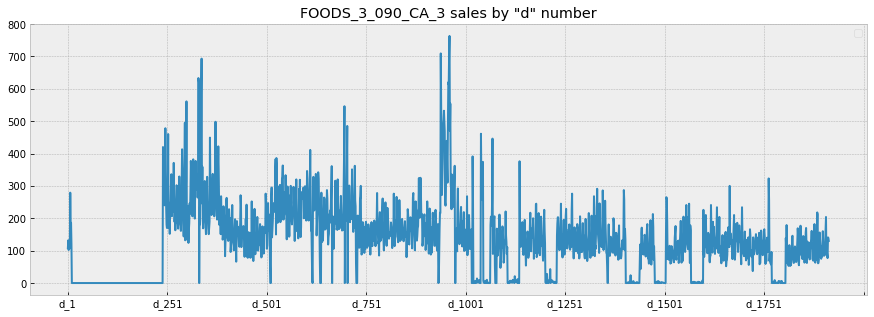

In [5]:
d_cols = [c for c in stv.columns if 'd_' in c] # sales data columns

# Below we are chaining the following steps in pandas:
# 1. Select the item.
# 2. Set the id as the index, Keep only sales data columns
# 3. Transform so it's a column
# 4. Plot the data
stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'] \
    .set_index('id')[d_cols] \
    .T \
    .plot(figsize=(15, 5),
          title='FOODS_3_090_CA_3 sales by "d" number',
          color=next(color_cycle))
plt.legend('')
plt.show()

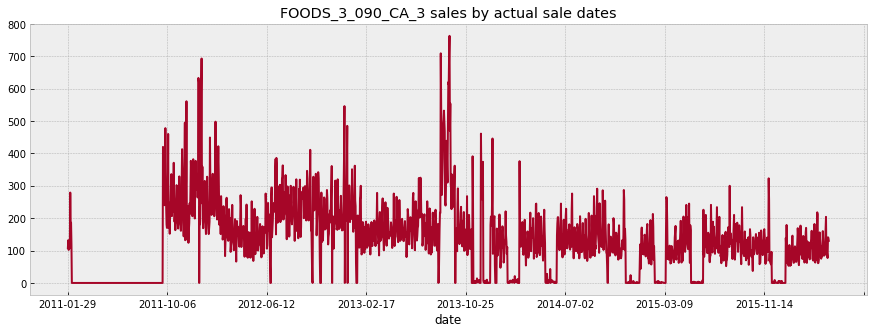

In [6]:
# Merge calendar on our items' data
example = stv.loc[stv['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Name it correctly
example = example.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example = example.merge(cal, how='left', validate='1:1')
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

In [7]:
stv.columns[:6]

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], dtype='object')

In [8]:
print(f'Number of unique items: {np.unique(stv.item_id).shape[0]}')
print(f'Number of unique department: {np.unique(stv.dept_id).shape[0]}')
print(f'Number of unique categories: {np.unique(stv.cat_id).shape[0]}')
print(f'Number of unique stores: {np.unique(stv.store_id).shape[0]}')
print(f'Number of unique states: {np.unique(stv.state_id).shape[0]}')

Number of unique items: 3049
Number of unique department: 7
Number of unique categories: 3
Number of unique stores: 10
Number of unique states: 3


In [9]:
# Transform column wide days to single column 

stv = stv.melt(list(stv.columns[:6]), var_name='day', value_vars=list(stv.columns[6:]), ignore_index=True)

In [10]:
# Group by the groups to consider (remove product_id as there are 3049 unique) 

stv = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id', 'day']).sum('value').reset_index()

In [11]:
days_calendar = np.concatenate((stv['day'].unique().reshape(-1,1), cal['date'][:-56].unique().reshape(-1,1)), axis=1)
df_caldays = pd.DataFrame(days_calendar, columns = ['day','Date'])

In [12]:
# Add calendar days

stv = stv.merge(df_caldays, how='left', on='day')

In [13]:
stv['Date'] = stv['Date'].astype('datetime64[ns]')
stv.dtypes

dept_id             object
cat_id              object
store_id            object
state_id            object
day                 object
value                int64
Date        datetime64[ns]
dtype: object

In [14]:
# Transform in weekly data

#stv_weekly = stv.groupby(['dept_id', 'cat_id', 'store_id', 'state_id']).resample('W', on='Date')['value'].sum()

<AxesSubplot:xlabel='Date'>

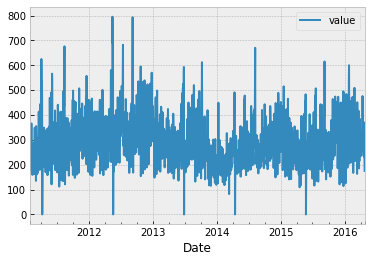

In [15]:
stv.loc[(stv.dept_id=='FOODS_1')&(stv.cat_id=='FOODS')&(stv.store_id=='CA_1')&(stv.state_id=='CA')][['Date', 'value']].set_index('Date').plot()

In [16]:
stv_fd = stv.loc[stv.Date > '2015-04-01']

In [17]:
# Build the structure to then apply the grouping transformation

stv_pivot = stv_fd.reset_index().pivot(index='Date',columns=['dept_id', 'cat_id', 'store_id', 'state_id'], values='value')
stv_pivot = stv_pivot.fillna(0)

In [18]:
stv_pivot

dept_id    FOODS_1                                              FOODS_2       \
cat_id       FOODS                                                FOODS        
store_id      CA_1 CA_2 CA_3 CA_4 TX_1 TX_2 TX_3 WI_1 WI_2 WI_3    CA_1 CA_2   
state_id        CA   CA   CA   CA   TX   TX   TX   WI   WI   WI      CA   CA   
Date                                                                           
2015-04-02     211  328  307  143  213  263  157  168  234  206     550  100   
2015-04-03     225  323  373  145  128  189  104  255  154  190     569  168   
2015-04-04     189  327  323  116  161  284  250  227  281  337     545  131   
2015-04-05     276  377  328  149  234  313  178  255  374  350     631  123   
2015-04-06     338  528  529  174  220  385  218  282  320  341     749  193   
...            ...  ...  ...  ...  ...  ...  ...  ...  ...  ...     ...  ...   
2016-04-20     370  468  347  200  206  275  261  348  259  249     448  141   
2016-04-21     291  526  428  180  200  244  263  279  226  181     549  164   
2016-04-22     231  345  297  190  216  207  158  212  212  145     383   92   
2016-04-23     247  299  285  192  143  224  207  243  182  180     322   84   
2016-04-24     175  291  273  187  148  225  184  198  276  152     277   57   

dept_id                                             FOODS_3                    \
cat_id                                                FOODS                     
store_id   CA_3 CA_4 TX_1 TX_2 TX_3 WI_1  WI_2 WI_3    CA_1  CA_2  CA_3  CA_4   
state_id     CA   CA   TX   TX   TX   WI    WI   WI      CA    CA    CA    CA   
Date                                                                            
2015-04-02  736  303  357  479  508  314   642  419    1724   783  2574   881   
2015-04-03  854  318  489  655  541   66   197  728    2342  1540  2936   934   
2015-04-04  683  328  329  347  347  364  1128  562    1662  1011  2493   887   
2015-04-05  870  249  313  484  412  465   929  609    2104  1195  2727   973   
2015-04-06  979  326  341  513  336  603   765  604    2635  1527  3592  1088   
...         ...  ...  ...  ...  ...  ...   ...  ...     ...   ...   ...   ...   
2016-04-20  613  223  350  469  355  336   535  216    2858  1828  3616  1337   
2016-04-21  672  285  381  471  325  339   430  322    3175  1637  4045  1375   
2016-04-22  560  274  306  390  364  273   359  233    2006  1096  3025  1280   
2016-04-23  441  240  230  341  266  232   387  214    1790  1074  2584  1093   
2016-04-24  483  201  218  361  244  274   417  209    1822  1018  2643   937   

dept_id           ... HOBBIES_2                     HOUSEHOLD_1             \
cat_id            ...   HOBBIES                       HOUSEHOLD              
store_id    TX_1  ...      TX_2 TX_3 WI_1 WI_2 WI_3        CA_1 CA_2  CA_3   
state_id      TX  ...        TX   TX   WI   WI   WI          CA   CA    CA   
Date              ...                                                        
2015-04-02  1274  ...        29   32   25   18   12         397  424   984   
2015-04-03  1455  ...        21   35   19   17   23         463  570   687   
2015-04-04  1226  ...        34   34   22   15   24         341  426   947   
2015-04-05  1546  ...        43   43   16   18   21         414  583   992   
2015-04-06  1607  ...        48   32   25   13   27         673  857  1327   
...          ...  ...       ...  ...  ...  ...  ...         ...  ...   ...   
2016-04-20  1752  ...        50   29   57   28   36         763  943  1678   
2016-04-21  1903  ...        73   39   17   19   20         955  952  1657   
2016-04-22  1393  ...        59   27   31   29   25         655  493  1348   
2016-04-23  1175  ...        49   47   47   27   21         495  460  1232   
2016-04-24  1265  ...        60   40   45   36   21         473  517  1104   

dept_id                                       HOUSEHOLD_2                      \
cat_id                                          HOUSEHOLD                       
store_id   

<AxesSubplot:xlabel='Date'>

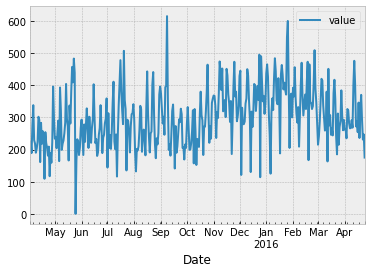

In [19]:
stv_fd.loc[(stv_fd.dept_id=='FOODS_1')&(stv_fd.cat_id=='FOODS')&(stv_fd.store_id=='CA_1')&(stv_fd.state_id=='CA')][['Date', 'value']].set_index('Date').plot()

In [20]:
groups_input = {
    'Department': [0],
    'Category': [1],
    'Store': [2],
    'State': [3]
}

In [21]:
# The dataset results from the removal of item_id (groupby by the ohter groups) and by downsampling to weekly data (the dataset was daily)

groups = generate_groups_data_flat(stv_pivot, groups_input, seasonality=7, h=30)

Number of groups: 4
	Department: 7
	Category: 3
	Store: 10
	State: 3
Total number of series: 70
Number of points per series for train: 359
Total number of points: 389
Seasonality: 7
Forecast horizon: 30


In [22]:
import pymc3 as pm
import theano.tensor as tt
import theano
import numpy as np
from libs.pre_processing import generate_groups_data_matrix_minibatch, generate_groups_data_matrix, data_transform

'''
Features:
1. The levels of the hierarchy that are used in the estimation 
    (i.e. considered to generate new gaussian processes) - 
    fewer levels don't use all the potential information 
    nested in the hierarchies but can boost performance
2. The seasonality to consider (i.e. the periodic 
    kernel defined for the cov function of the GP)
3. Option to define a piecewise function for the GP mean and respective
    selection of the number of changepoints - avoiding the need to apply 
    first differnece to the data
4. Option to define a linear function (defined as log linear considering 
    the log-link function used with the Poisson distribution)
5. Option to use MAP or VI to estimate the parameter values (VI is advised 
    using normal likelihood)
6. Possibility to use Minibatch that ensures scalability of the model
7. Option to choose Poisson or Normal likelihood (for the normal case,
    it is assumed that the data is standardized)
8. Possibility to define a linear kernel to model the linear trend of the data
    avoiding the need to apply first difference to the data
9. Option to partially pool all parameters using hyperpriors per group
10. Select only partial pooling on the mean
'''

class LogLinear(pm.gp.mean.Mean):
    # Log linear mean function to get diminishing returns on the GP mean functions
    # -> adding 1 to avoid inf when X = 0
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(tt.log(X+1), self.b) + self.a)


class Linear(pm.gp.mean.Mean):
    # This linear function with a log-link function results in an 
    # exponential mean 
    def __init__(self, b, a=0):
        self.a = a
        self.b = b

    def __call__(self, X):
        return tt.squeeze(tt.dot(X, self.b) + self.a)


class PiecewiseLinearChangepoints(pm.gp.mean.Mean):
    # Piecewise linear function to be used as the mean function of the GPs
    def __init__(self, 
                 k, 
                 m,
                 b,
                 intercept, 
                 changepoints,
                 groups, 
                 minibatch):
        self.k = k
        self.m = m
        self.b = b
        self.a = intercept
        self.g = groups
        self.changepoints = changepoints
        self.minibatch = minibatch

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def __call__(self, X):
        
        if not self.minibatch:
            # with minibatch X is already a theano variable
            X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k + tt.dot(A, self.b.reshape((-1,1))))*X + (self.m + tt.dot(A, (-self.changepoints * self.b).reshape((-1,1))))

        return (piecewise + self.a).reshape((-1,))


class OutPiecewiseLinearChangepoints():
    # Piecewise linear function applied outside of the GPs and added in the likelihood parameter
    def __init__(self, 
                 k, 
                 m,
                 b,
                 changepoints,
                 groups):
        self.k = k
        self.m = m
        self.b = b
        self.g = groups
        self.changepoints = changepoints

    def create_changepoints(self, X, changepoints):
        return (0.5 * (1.0 + tt.sgn(tt.tile(X.reshape((-1,1)), (1,len(changepoints))) - changepoints)))

    def build(self, X):
        size_r = X.shape[0]

        X = theano.shared(X)
            
        A = self.create_changepoints(X, self.changepoints)

        piecewise = (self.k.reshape((1, -1)) + tt.dot(A, self.b))*tt.tile(X, (1, self.g['train']['s'])) + (self.m.reshape((1,-1)) + tt.dot(A, (-self.changepoints.reshape((-1,1)) * self.b)))
        
        return piecewise


class HGPforecaster:
    """HGP forecaster
    Parameters
    ----------
    groups_data: dict
                train
                predict
                    'groups_idx'
                    'groups_n'
                    'groups_names'
                    'n'
                    's'
                    'n_series_idx'
                    'n_series'
                    'g_number'
                    'data'
                seasonality
                horizon
    levels: list
                levels to be used in the estimation (default uses all levels)
    changepoints: int
                define a piecewise function as the mean of the GPs based on the number of 
                changepoints defined by the user (uniformly distributed across time)
    n_iterations: int
                number of iterations to run on the optimization (MAP or VI)
    minibatch: list[n_points, n_series]
                list with number of points and number of series to consider
    log_lin_mean: bool
                define a linear (log-linear considering the log-link function used) 
                function as the mean of the GP
    likelihood: list
            ['normal', 'poisson'] -> possibility to choose to use a normal likelihood (it is assumed that 
            the data is standardized) or a poisson likelihood
    piecewise_out: bool
            possibility to define a piecewise linear function outside of the GPs definition. It will be summed 
            to the GPs output in the likelihood
    kernel_lin_mean: bool
            possibility to define a linear kernel to model the linear trend of the data avoiding the 
            need to apply first difference to the data
    partial_pool: bool
            option to partially pool all parameters using hyperpriors per group. Default to False
    partial_pool_mean: bool
            select partial pooling only on the mean. Defaul to true
    """
    def __init__(
        self,
        groups_data,
        levels=None,
        changepoints=None,
        n_iterations=10000,
        minibatch=None,
        log_lin_mean=None,
        likelihood='normal',
        piecewise_out = False,
        kernel_lin_mean=None,
        partial_pool=False,
        partial_pool_mean=True
    ):
        self.model = pm.Model()
        self.priors = {}
        self.g = groups_data
        self.y_pred = None
        self.mp = None
        self.gp_dict={}
        self.pred_samples_fit=None
        self.pred_samples_predict=None
        self.season = self.g['seasonality']
        self.n_iterations = n_iterations
        self.trace_vi = None
        self.pred_samples_fit = None
        self.trace_vi_samples = None
        self.likelihood = likelihood
        self.piecewise_out = piecewise_out

        self.kernel_lin_mean = kernel_lin_mean
        self.partial_pool = partial_pool
        self.partial_pool_mean = partial_pool

        if changepoints:
            self.changepoints = np.linspace(0, self.g['train']['n'], changepoints+2)[1:-1]
        else:
            self.changepoints = np.array(())

        if levels:
            self.levels = levels
        else:
            self.levels = list(self.g['train']['groups_names'].keys())

        self.minibatch = minibatch
        self.log_lin_mean = log_lin_mean

        # transform the data to matrix form
        self.g = generate_groups_data_matrix(self.g)
        self.dt = data_transform(self.g)

        if self.likelihood == 'normal':
            # if likelihood is normal standardize data
            self.g = self.dt.std_transf_train()

        # to use minibatch transform the arrays to minibatch tensors
        if self.minibatch:
            self.g, self.X_mi = generate_groups_data_matrix_minibatch(self.g, self.minibatch[0], self.minibatch[1])

        self.X = np.arange(self.g['train']['n']).reshape(-1,1)

    def generate_priors(self):
        """Set up the priors for the model."""
        with self.model:

            if self.minibatch:
                self.series = self.g['train']['n_series_idx'].eval()
            else:
                self.series = self.g['train']['n_series_idx']
            
            self.series_full = self.g['train']['n_series_idx_full']

            if self.likelihood=='poisson':
                # In the case of the normal likelihood it is assumed that the data is standardized
                self.priors["a0"] = pm.Normal(
                    "a0", 
                    mu=tt.log(np.mean(self.g['train']['full_data'][:,self.series_full], axis=0)), 
                    sd=0.2, 
                    shape = self.g['train']['s'])
            else:
                # In the case of a normal likelihood we need to define sigma
                self.priors['sigma'] = pm.HalfNormal(
                    'sigma',
                    0.01,
                    shape = self.g['train']['s'])

            if self.piecewise_out:
                if self.likelihood == 'poisson':
                    if self.partial_pool_mean:
                        # priors for the group effects
                        # we want a partial pooling effect, so reduce the sd of the several parameters,
                        # while defining a wider hyperparameter
                        self.priors["hy_b_%s" %group] = pm.Normal(
                            "hy_b_%s" %group, 
                            mu=0.0, 
                            sd=0.001)
                        self.priors["hy_k_%s" %group] = pm.Normal(
                            'hy_k_%s' %group, 
                            0.0,
                            0.001)
                        self.priors["hy_m_%s" %group] = pm.Normal(
                            'hy_m_%s' %group, 
                            0.0,
                            0.001)       
                        # Partially pooled parameters
                        self.priors["b_%s" %group] = pm.Normal(
                            "b_%s" %group, 
                            self.priors["hy_b_%s" %group], 
                            0.0001,
                            shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            "k_%s" %group, 
                            self.priors["hy_k_%s" %group], 
                            0.0001,
                            shape=self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            "m_%s" %group, 
                            self.priors["hy_m_%s" %group], 
                            0.0001,
                            shape=self.g['train']['groups_n'][group])
                    else:
                        self.priors["k"] = pm.Normal(
                            'k',
                            0.0,
                            0.01,
                            shape = self.g['train']['s'])
                        self.priors["m"] = pm.Normal(
                            'm', 
                            0.0,
                            0.01,
                            shape = self.g['train']['s'])

                        self.priors["b"] = pm.Normal(
                            'b', 
                            0.,
                            0.01,
                            shape = (self.changepoints.shape[0], self.g['train']['s']))     
                else:
                    # Normal likelihood
                    if self.partial_pool_mean:
                        # priors for the group effects
                        # we want a partial pooling effect, so reduce the sd of the several parameters,
                        # while defining a wider hyperparameter
                        self.priors["hy_b_%s" %group] = pm.Normal(
                            "hy_b_%s" %group, 
                            mu=0.0, 
                            sd=0.01)
                        self.priors["hy_k_%s" %group] = pm.Normal(
                            'hy_k_%s' %group, 
                            0.0,
                            0.01)
                        self.priors["hy_m_%s" %group] = pm.Normal(
                            'hy_m_%s' %group, 
                            0.0,
                            0.01)       
                        # Partially pooled parameters
                        self.priors["b_%s" %group] = pm.Normal(
                            "b_%s" %group, 
                            self.priors["hy_b_%s" %group], 
                            0.001,
                            shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                        self.priors["k_%s" %group] = pm.Normal(
                            "k_%s" %group, 
                            self.priors["hy_k_%s" %group], 
                            0.001,
                            shape=self.g['train']['groups_n'][group])
                        self.priors["m_%s" %group] = pm.Normal(
                            "m_%s" %group, 
                            self.priors["hy_m_%s" %group], 
                            0.001,
                            shape=self.g['train']['groups_n'][group])
                    else:
                        self.priors["k"] = pm.Normal(
                            'k',
                            0.0,
                            0.01,
                            shape = self.g['train']['s'])
                        self.priors["m"] = pm.Normal(
                            'm', 
                            0.0,
                            0.01,
                            shape = self.g['train']['s'])
                        self.priors["b"] = pm.Normal(
                            'b', 
                            0.,
                            0.01,
                            shape = (self.changepoints.shape[0], self.g['train']['s']))                        

            # prior for the periodic kernel (seasonality)
            self.priors["period"] = pm.Laplace(
                    "period", self.season, 0.1)

            for group in self.levels:

                if self.partial_pool:
                    # priors for the kernels of each group

                    # The inverse gamma is very useful to inform our prior dist of the length scale
                    # because it supresses both zero and infinity.
                    # The data don't inform length scales larger than the maximum covariate distance 
                    # and shorter than the minimum covariate distance (distance between time points which 
                    # is always 1 in our case).

                    # Parameters expQuad kernel
                    self.priors["hy_l_t_%s" %group] = pm.InverseGamma(
                        'hy_l_t_%s' %group, 
                        4, 
                        self.g['train']['n'])
                    self.priors["hy_eta_t_%s" %group] = pm.HalfNormal(
                        'hy_eta_t_%s' %group, 
                        1)

                    # Parameters periodic kernel
                    self.priors["hy_l_p_%s" %group] = pm.HalfNormal(
                        'hy_l_p_%s' %group, 
                         0.5)
                    self.priors["hy_eta_p_%s" %group] = pm.HalfNormal(
                        'hy_eta_p_%s' %group, 
                        1.5)

                    # Parameters white noise kernel
                    self.priors["hy_sigma_%s" %group] = pm.HalfNormal(
                        'hy_sigma_%s' %group, 
                        0.001)

                    # Partially pooled parameters
                    self.priors["l_t_%s" %group] = pm.Normal(
                        "l_t_%s" %group, 
                        self.priors["hy_l_t_%s" %group], 
                        0.1,
                        shape=self.g['train']['groups_n'][group])
                    self.priors["eta_t_%s" %group] = pm.Normal(
                        "eta_t_%s" %group, 
                        self.priors["hy_eta_t_%s" %group], 
                        0.1,
                        shape=self.g['train']['groups_n'][group])
                    self.priors["l_p_%s" %group] = pm.Normal(
                        "l_p_%s" %group, 
                        self.priors["hy_l_p_%s" %group], 
                        0.1,
                        shape=self.g['train']['groups_n'][group])
                    self.priors["eta_p_%s" %group] = pm.Normal(
                        "eta_p_%s" %group, 
                        self.priors["hy_eta_p_%s" %group], 
                        0.1,
                        shape=self.g['train']['groups_n'][group])
                    self.priors["sigma_%s" %group] = pm.Normal(
                        "sigma_%s" %group, 
                        self.priors["hy_sigma_%s" %group], 
                        0.1,
                        shape=self.g['train']['groups_n'][group])             

                    if self.log_lin_mean:
                        self.priors["hy_b_%s" %group] = pm.Normal(
                            "hy_b_%s" %group, 
                            mu=0.0, 
                            sd=0.01)
                        self.priors["b_%s" %group] = pm.Normal(
                            'b_%s' %group, 
                            self.priors["hy_b_%s" %group],
                            0.005,
                            shape = self.g['train']['groups_n'][group])
                    elif self.piecewise_out:
                        pass
                    elif np.any(self.changepoints):
                        if self.likelihood == 'poisson':
                            # Priors for hyperparamters
                            self.priors["hy_b_%s" %group] = pm.Normal(
                                "hy_b_%s" %group, 
                                mu=0.0, 
                                sd=0.1)
                            self.priors["hy_k_%s" %group] = pm.Normal(
                                'hy_k_%s' %group, 
                                0.0,
                                0.1)
                            self.priors["hy_m_%s" %group] = pm.Normal(
                                'hy_m_%s' %group, 
                                0.0,
                                0.1)  
                            # priors for the group effects
                            self.priors["b_%s" %group] = pm.Normal(
                                "b_%s" %group, 
                                self.priors["hy_b_%s" %group], 
                                0.005,
                                shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                            self.priors["k_%s" %group] = pm.Normal(
                                "k_%s" %group, 
                                self.priors["hy_k_%s" %group], 
                                0.005,
                                shape=self.g['train']['groups_names'][group])
                            self.priors["m_%s" %group] = pm.Normal(
                                "m_%s" %group, 
                                self.priors["hy_m_%s" %group], 
                                0.005,
                                shape=self.g['train']['groups_names'][group])
                        else:
                            # Parameters for the piecewise linear function defined as GPs mean functions
                            # with a normal likelihood -> wider intervals as we don't have the log-link
                            # function
                            self.priors["hy_b_%s" %group] = pm.Normal(
                                "hy_b_%s" %group, 
                                mu=0.0, 
                                sd=0.1)
                            self.priors["hy_k_%s" %group] = pm.Normal(
                                'hy_k_%s' %group, 
                                0.0,
                                0.1)
                            self.priors["hy_m_%s" %group] = pm.Normal(
                                'hy_m_%s' %group, 
                                0.0,
                                0.1)                            
                            # priors for the group effects
                            # we want a partial pooling effect, so reduce the sd of the several parameters,
                            # while defining a wider hyperparameter
                            # Partially pooled parameters
                            self.priors["b_%s" %group] = pm.Normal(
                                "b_%s" %group, 
                                self.priors["hy_b_%s" %group], 
                                0.01,
                                shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                            self.priors["k_%s" %group] = pm.Normal(
                                "k_%s" %group, 
                                self.priors["hy_k_%s" %group], 
                                0.01,
                                shape=self.g['train']['groups_n'][group])
                            self.priors["m_%s" %group] = pm.Normal(
                                "m_%s" %group, 
                                self.priors["hy_m_%s" %group], 
                                0.01,
                                shape=self.g['train']['groups_n'][group])

                    elif self.kernel_lin_mean:
                        # Parameters linear kernel to model the mean of the GP
                        if self.likelihood=='poisson':
                            self.priors["c_%s" %group] = pm.Normal(
                                'c_%s' %group, 
                                self.g['train']['n']/2, 
                                5)
                            self.priors["sigma_l_%s" %group] = pm.HalfNormal(
                                'sigma_l_%s' %group, 
                                0.01)

                            # Partially pooled parameters
                            self.priors["c_%s" %group] = pm.Normal(
                                "c_%s" %group, 
                                self.priors["hy_c_%s" %group], 
                                1,
                                shape=self.g['train']['groups_n'][group])
                            self.priors["sigma_l_%s" %group] = pm.Normal(
                                "sigma_l_%s" %group, 
                                self.priors["hy_sigma_l_%s" %group], 
                                0.01,
                                shape=self.g['train']['groups_n'][group])
                        else:
                            self.priors["hy_c_%s" %group] = pm.Normal(
                                'hy_c_%s' %group, 
                                self.g['train']['n']/2, 
                                5)
                            self.priors["hy_sigma_l_%s" %group] = pm.HalfNormal(
                                'hy_sigma_l_%s' %group, 
                                0.1)

                            # Partially pooled parameters
                            self.priors["c_%s" %group] = pm.Normal(
                                "c_%s" %group, 
                                self.priors["hy_c_%s" %group], 
                                0.1,
                                shape=self.g['train']['groups_n'][group])
                            self.priors["sigma_l_%s" %group] = pm.Normal(
                                "sigma_l_%s" %group, 
                                self.priors["hy_sigma_l_%s" %group], 
                                0.01,
                                shape=self.g['train']['groups_n'][group])

                else:
                    # Initialization not using partial pooling

                    # Parameters expQuad kernel
                    self.priors["l_t_%s" %group] = pm.InverseGamma(
                        'l_t_%s' %group, 
                        4, 
                        self.g['train']['n'], 
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_t_%s" %group] = pm.HalfNormal(
                        'eta_t_%s' %group, 
                        1,
                        shape = self.g['train']['groups_n'][group])

                    # Parameters periodic kernel
                    self.priors["l_p_%s" %group] = pm.HalfNormal(
                        'l_p_%s' %group, 
                        0.5,
                        shape = self.g['train']['groups_n'][group])
                    self.priors["eta_p_%s" %group] = pm.HalfNormal(
                        'eta_p_%s' %group, 
                        1.5, 
                        shape = self.g['train']['groups_n'][group])

                    # Parameters white noise kernel
                    self.priors["sigma_%s" %group] = pm.HalfNormal(
                        'sigma_%s' %group, 
                        0.001,
                        shape = self.g['train']['groups_n'][group])

                    if self.log_lin_mean:
                        self.priors["hy_b_%s" %group] = pm.Normal(
                            "hy_b_%s" %group, 
                            mu=0.0, 
                            sd=0.01)
                        self.priors["b_%s" %group] = pm.Normal(
                            'b_%s' %group, 
                            self.priors["hy_b_%s" %group],
                            0.005,
                            shape = self.g['train']['groups_n'][group])
                    elif self.piecewise_out:
                        pass
                    elif np.any(self.changepoints):
                        if self.partial_pool_mean:
                            if self.likelihood == 'poisson':
                                # Priors for hyperparamters
                                self.priors["hy_b_%s" %group] = pm.Normal(
                                    "hy_b_%s" %group, 
                                    mu=0.0, 
                                    sd=0.1)
                                self.priors["hy_k_%s" %group] = pm.Normal(
                                    'hy_k_%s' %group, 
                                    0.0,
                                    0.1)
                                self.priors["hy_m_%s" %group] = pm.Normal(
                                    'hy_m_%s' %group, 
                                    0.0,
                                    0.1)  
                                # priors for the group effects
                                self.priors["b_%s" %group] = pm.Normal(
                                    "b_%s" %group, 
                                    self.priors["hy_b_%s" %group], 
                                    0.005,
                                    shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                                self.priors["k_%s" %group] = pm.Normal(
                                    "k_%s" %group, 
                                    self.priors["hy_k_%s" %group], 
                                    0.005,
                                    shape=self.g['train']['groups_names'][group])
                                self.priors["m_%s" %group] = pm.Normal(
                                    "m_%s" %group, 
                                    self.priors["hy_m_%s" %group], 
                                    0.005,
                                    shape=self.g['train']['groups_names'][group])
                            else:
                                # Parameters for the piecewise linear function defined as GPs mean functions
                                # with a normal likelihood -> wider intervals as we don't have the log-link
                                # function
                                self.priors["hy_b_%s" %group] = pm.Normal(
                                    "hy_b_%s" %group, 
                                    mu=0.0, 
                                    sd=0.1)
                                self.priors["hy_k_%s" %group] = pm.Normal(
                                    'hy_k_%s' %group, 
                                    0.0,
                                    0.1)
                                self.priors["hy_m_%s" %group] = pm.Normal(
                                    'hy_m_%s' %group, 
                                    0.0,
                                    0.1)                            
                                # priors for the group effects
                                # we want a partial pooling effect, so reduce the sd of the several parameters,
                                # while defining a wider hyperparameter
                                # Partially pooled parameters
                                self.priors["b_%s" %group] = pm.Normal(
                                    "b_%s" %group, 
                                    self.priors["hy_b_%s" %group], 
                                    0.01,
                                    shape=(self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                                self.priors["k_%s" %group] = pm.Normal(
                                    "k_%s" %group, 
                                    self.priors["hy_k_%s" %group], 
                                    0.01,
                                    shape=self.g['train']['groups_n'][group])
                                self.priors["m_%s" %group] = pm.Normal(
                                    "m_%s" %group, 
                                    self.priors["hy_m_%s" %group], 
                                    0.01,
                                    shape=self.g['train']['groups_n'][group])
                        else:
                            if self.likelihood == 'poisson':
                                # Priors for hyperparamters
                                # priors for the group effects
                                self.priors["b_%s" %group] = pm.Normal(
                                    'b_%s' %group, 
                                    0.0,
                                    0.005,
                                    shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                                self.priors["k_%s" %group] = pm.Normal(
                                    'k_%s' %group, 
                                    0.0,
                                    0.005,
                                    shape = self.g['train']['groups_n'][group])
                                self.priors["m_%s" %group] = pm.Normal(
                                    'm_%s' %group, 
                                    0.0,
                                    0.005,
                                    shape = self.g['train']['groups_n'][group])
                            else:
                                # Parameters for the piecewise linear function defined as GPs mean functions
                                # with a normal likelihood -> wider intervals as we don't have the log-link
                                # function
                                self.priors["b_%s" %group] = pm.Normal(
                                    'b_%s' %group, 
                                    0.0,
                                    0.05,
                                    shape = (self.changepoints.shape[0], self.g['train']['groups_n'][group]))
                                self.priors["k_%s" %group] = pm.Normal(
                                    'k_%s' %group, 
                                    0.0,
                                    0.1,
                                    shape = self.g['train']['groups_n'][group])
                                self.priors["m_%s" %group] = pm.Normal(
                                    'm_%s' %group, 
                                    0.0,
                                    0.1,
                                    shape = self.g['train']['groups_n'][group])
                    elif self.kernel_lin_mean:
                        # Parameters linear kernel to model the mean of the GP
                        if self.likelihood=='poisson':
                            self.priors["c_%s" %group] = pm.Normal(
                                'c_%s' %group, 
                                0,
                                0.1, 
                                shape = self.g['train']['groups_n'][group])
                            self.priors["eta_l_%s" %group] = pm.HalfNormal(
                                'eta_l_%s' %group, 
                                0.01,
                                shape = self.g['train']['groups_n'][group])
                        else:
                            self.priors["c_%s" %group] = pm.Normal(
                                'c_%s' %group, 
                                0, 
                                0.1,
                                shape = self.g['train']['groups_n'][group])
                            self.priors["sigma_l_%s" %group] = pm.HalfNormal(
                                'sigma_l_%s' %group, 
                                1,
                                shape = self.g['train']['groups_n'][group])


    def generate_GPs(self):
        self.generate_priors()
        
        gp_dict = {}
        f_dict = {}
        f_flat = {}
        idx_dict = {}
        
        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['train']['groups_names'][group]):

                    # mean function for the GP with specific parameters per group

                    if self.log_lin_mean:
                        mu_func = LogLinear(b = self.priors["b_%s" %group][idx])
                        
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx]) 
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))
                    elif self.piecewise_out:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif np.any(self.changepoints):
                        mu_func = PiecewiseLinearChangepoints(intercept = np.zeros(1),
                                                              b = self.priors["b_%s" %group][:, idx],
                                                              changepoints = self.changepoints,
                                                              k = self.priors["k_%s" %group][idx],
                                                              m = self.priors["m_%s" %group][idx],
                                                              groups = self.g,
                                                              minibatch = self.minibatch)

                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])                                
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    elif self.kernel_lin_mean:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + self.priors["sigma_l_%s" %group][idx]**2 * pm.gp.cov.Linear(1, c=self.priors["c_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    else:
                        mu_func = pm.gp.mean.Zero()

                        # cov function for the GP with specific parameters per group
                        cov = (self.priors["eta_t_%s" %group][idx]**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=self.priors["l_t_%s" %group][idx])
                                + self.priors["eta_p_%s" %group][idx]**2 * pm.gp.cov.Periodic(1, period=self.priors["period"], ls=self.priors["l_p_%s" %group][idx]) 
                                + pm.gp.cov.WhiteNoise(self.priors["sigma_%s" %group][idx]))

                    if self.minibatch:
                        # index varible that indicates where a specific GP is active
                        # for instance, GP_fem is only active in fem time series
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group].eval()==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X_mi, reparameterize=True, shape = self.minibatch[0])
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))
                    else:
                        idx_dict[name] = np.where(self.g['train']['groups_idx'][group]==idx,1,0)

                        self.gp_dict[name] = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
                        f_dict[name] = self.gp_dict[name].prior('f_%s' % name, X=self.X, reparameterize=True)
                        f_flat[name] = f_dict[name].reshape((-1,1)) * idx_dict[name].reshape((1,-1))

            self.f = sum(f_flat.values())
        
    def likelihood_fn(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            # Using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    # defining a poisson likelihood
                    self.y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(self.f + self.priors['a0'][self.series].reshape((1,-1))), 
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))
                else:
                    # defining a normal likelihood with minibatch
                    self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'][self.series].reshape((1,-1)),
                                observed=self.g['train']['data'], 
                                total_size=(self.g['train']['n'],self.g['train']['s']))

        else:
            # Not using minibatch
            with self.model:
                if self.likelihood=='poisson':
                    # defining a poisson likelihood
                    if self.piecewise_out:
                        # poisson likelihood with a piecewise function summed
                        piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                            m = self.priors["m"],
                                                            b = self.priors['b'],
                                                            changepoints = self.changepoints,
                                                            groups = self.g).build(self.X)
                        self.y_pred = pm.Poisson('y_pred', 
                            mu=tt.exp(self.f + self.priors['a0'].reshape((1,-1)) + piece), 
                            observed=self.g['train']['data'])
                    else:
                        # not using a piecewise linear function outside of the GPs
                        self.y_pred = pm.Poisson('y_pred', 
                                mu=tt.exp(self.f + self.priors['a0'][self.series].reshape((1,-1))), 
                                observed=self.g['train']['data'])
                else:
                    if self.piecewise_out:
                        # normal likelihood with a piecewise function summed
                        piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                            m = self.priors["m"],
                                                            b = self.priors['b'],
                                                            changepoints = self.changepoints,
                                                            groups = self.g).build(self.X)
                        self.y_pred = pm.Normal('y_pred', 
                            mu=self.f + piece, 
                            sd=self.priors['sigma'],
                            observed=self.g['train']['data'])
                    else:
                        # normal likelihood without minibatch
                        self.y_pred = pm.Normal('y_pred', 
                                mu=self.f,
                                sd=self.priors['sigma'],
                                observed=self.g['train']['data'])


    def prior_predictive_checks(self):
        # Avoid generating priors if already created
        if not self.priors:
            self.generate_GPs()

        if self.minibatch:
            raise NotImplementedError("Please do your prior predictive checks without using minibatch")

        with self.model:
            if self.likelihood=='poisson':
                # defining a poisson likelihood
                if self.piecewise_out:
                    # poisson likelihood with a piecewise function summed
                    piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                        m = self.priors["m"],
                                                        b = self.priors['b'],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(self.X)
                    # this value is the value used as the lambda for the poisson likelihood
                    self.prior_like = pm.Poisson('prior_like', 
                                        mu=tt.exp(self.f + self.priors['a0'].reshape((1,-1)) + piece),
                                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))
                else:
                    # not using a piecewise linear function outside of the GPs
                    self.prior_like = pm.Poisson('prior_like', 
                                        mu=tt.exp(self.f + self.priors['a0'].reshape((1,-1)) + piece),
                                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))
            else:
                if self.piecewise_out:
                    # normal likelihood with a piecewise function summed
                    piece = OutPiecewiseLinearChangepoints(k = self.priors["k"],
                                                        m = self.priors["m"],
                                                        b = self.priors['b'],
                                                        changepoints = self.changepoints,
                                                        groups = self.g).build(self.X)
                    self.prior_like = pm.Normal('prior_like', 
                        mu=self.f + piece, 
                        sd=self.priors['sigma'],
                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))
                else:
                    # normal likelihood
                    self.prior_like = pm.Normal('prior_like', 
                        mu=self.f, 
                        sd=self.priors['sigma'],
                        shape=(self.g['train']['data'].shape[0], self.g['train']['data'].shape[1]))

            self.prior_checks = pm.sample_prior_predictive(200)

    def fit_map(self):
        self.likelihood_fn()

        if self.minibatch:
            raise ValueError('Cannot use MAP with minibatch. Please call the `fit_vi` method.')

        with self.model:
            print('Fitting model...')
            self.mp = pm.find_MAP(maxeval=self.n_iterations)
            print('Sampling...')
            self.pred_samples_fit = pm.sample_posterior_predictive([self.mp], 
                                                    vars=[self.y_pred], 
                                                    samples=500)
            
    def fit_vi(self):
        self.likelihood_fn()
        with self.model:
            print('Fitting model...')
            self.trace_vi = pm.fit(self.n_iterations,
                                   method='advi',
                                   # Stochastic nature of VI in PyMC3. In PyMC3, VI uses MC sample to approximate the objective gradients. 
                                   # As a consequence, the result of the fit is stochastic - you can see that in the ELBO it is not always decreasing. 
                                   # So when you stop the training, VI return the fitting from the last iteration, which can happen to have high ELBO. 
                                   # Solution is to increase the obj_n_mc - Number of monte carlo samples used for approximation of objective gradients. 
                                   obj_n_mc=1,
                                   obj_optimizer=pm.adamax(),
                                   # Defining a callback to do early stop when convergence is achieved
                                   callbacks=[pm.callbacks.CheckParametersConvergence(every=50, diff='absolute',tolerance=1e-3)])
            print('Sampling...')
            self.trace_vi_samples = self.trace_vi.sample()
            self.pred_samples_fit = pm.sample_posterior_predictive(self.trace_vi_samples,
                                                                   vars=[self.y_pred],
                                                                   samples=500)
    
        if not self.minibatch:
            # with minibatch there is no possibility to recover the fitted values
            # backtransform the sampling of the fit for the original scale
            if self.likelihood == 'normal':
                self.pred_samples_fit = self.dt.inv_transf_train_general(self.pred_samples_fit['y_pred'])


    def predict(self):
        f_new = {}
        f_flat_new = {}
        idx_dict_new = {}

        n_new = self.g['predict']['n']
        X_new = np.arange(n_new).reshape(-1,1)

        with self.model:
            for group in self.levels:
                for idx, name in enumerate(self.g['predict']['groups_names'][group]):
                    idx_dict_new[name] = np.where(self.g['predict']['groups_idx'][group]==idx,1,0)
                    f_new[name] = self.gp_dict[name].conditional('f_new%s'%name, Xnew = X_new)
                    f_flat_new[name] = f_new[name].reshape((-1,1)) * idx_dict_new[name].reshape((1,-1))

            f_ = sum(f_flat_new.values())

            if self.likelihood=='poisson':
                if self.piecewise_out:
                    piece = OutPiecewiseLinearChangepoints(k = self.priors['k'],
                                                m = self.priors['m'],
                                                b = self.priors['b'],
                                                changepoints = self.changepoints,
                                                groups = self.g).build(X_new)

                    y_pred_new = pm.Poisson("y_pred_new", 
                                    mu=tt.exp(f_ + self.priors['a0'].reshape((1,-1)) + piece), 
                                    shape=(n_new, self.g['predict']['s']))
                else:
                    y_pred_new = pm.Poisson("y_pred_new", 
                                    mu=tt.exp(f_ + self.priors['a0'].reshape((1,-1))), 
                                    shape=(n_new, self.g['predict']['s']))
            else:
                if self.piecewise_out:
                    piece = OutPiecewiseLinearChangepoints(k = self.priors['k'],
                                                m = self.priors['m'],
                                                b = self.priors['b'],
                                                changepoints = self.changepoints,
                                                groups = self.g).build(X_new)

                    y_pred_new = pm.Normal("y_pred_new", 
                                    mu=f_ + piece,
                                    sd=self.priors['sigma'],
                                    shape=(n_new, self.g['predict']['s']))
                else:
                    y_pred_new = pm.Normal("y_pred_new", 
                                    mu=f_, 
                                    sd=self.priors['sigma'],
                                    shape=(n_new, self.g['predict']['s']))
            print('Sampling...')
            if self.trace_vi_samples:
                # Sampling using trace from VI
                self.pred_samples_predict = pm.sample_posterior_predictive(self.trace_vi_samples, 
                                              vars=[y_pred_new], 
                                              samples=500)
            else:
                # Sampling using points from MAP
                self.pred_samples_predict = pm.sample_posterior_predictive([self.mp], 
                              vars=[y_pred_new], 
                              samples=500)

        # backtransform the data and predictions to the original scale
        if self.likelihood == 'normal':
            if self.minibatch:   
                self.g['train']['data'] = self.g['train']['full_data'] 
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])
            else:
                self.g = self.dt.inv_transf_train()
                self.pred_samples_predict = self.dt.inv_transf_predict_general(self.pred_samples_predict['y_pred_new'])

In [23]:
# Instantiate the model class
m = HGPforecaster(groups_data=groups,
                  n_iterations=100000,
                  changepoints = 4,
                  piecewise_out=True)

In [24]:
# Fit and predict
m.fit_vi()
m.predict()

Fitting model...


Finished [100%]: Average Loss = 1.1743e+05


Sampling...


Sampling...


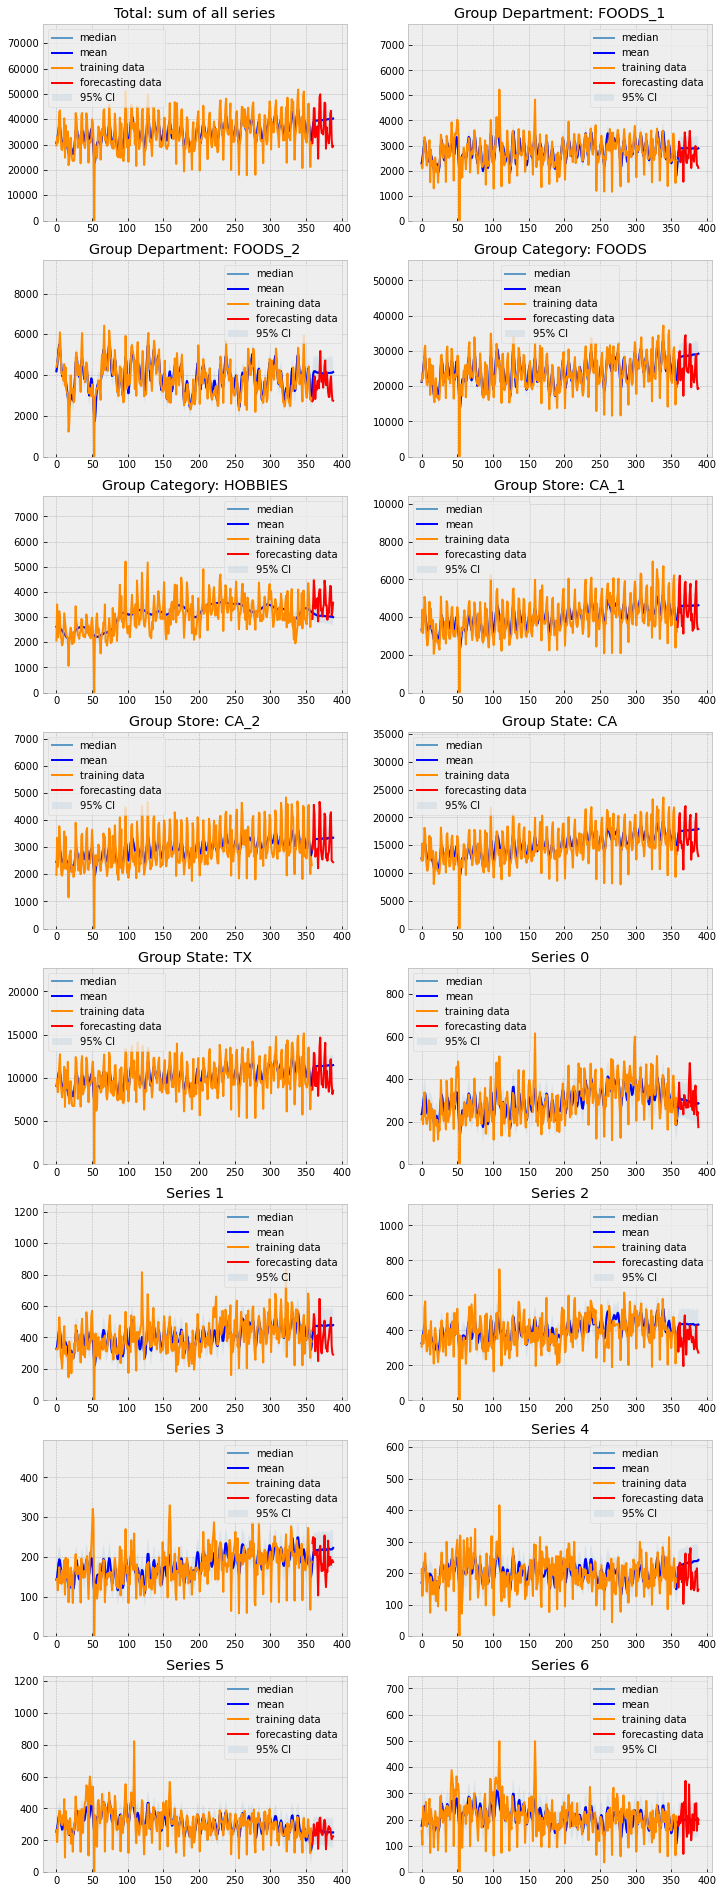

In [25]:
# Visualize your predictions and credible intervals
visualize_predict(groups, m.pred_samples_predict, 8)

In [26]:
# Print the overall resuls
results = calculate_metrics(m.pred_samples_predict, groups)
metrics_to_table(results)

,bottom,total,Department,Category,Store,State,all
mase,0.888,1.049,0.987,1.047,0.952,0.985,0.899
rmse,142.601,6998.944,1191.588,2689.329,780.989,2427.004,599.69
